# Text augmentation using nlpaug

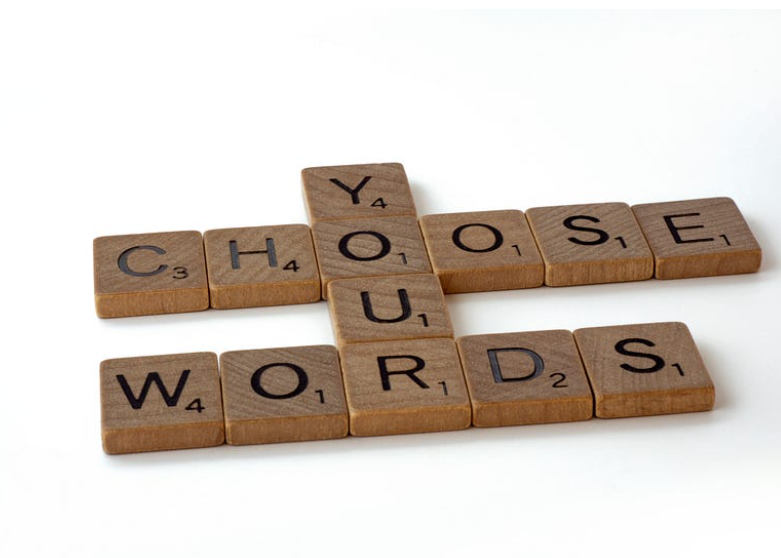


**Motivation** 

Usually, the augmented data is similar to the data that is already available. In all Machine Learning problems the dataset determines how well the problem can be solved. Sometimes we don’t have enough data to build robust models, and what’s even more common is **having data with a palpable class imbalance**. In such a case our model will almost always predict the class with more samples since it has not been given enough data to discern between the classes. We must then turn to collecting more data, but what if we can’t? One way is to generate exact copies of the data samples that we have and decrease the imbalance. Although this does provide some improvement, the model is still learning from the same set of features! Perhaps a few artful tweaks can improve the quality of data we have.

**Why NLPaug**

However, augmenting text data is very difficult. For instance changing the order of words may at first seem plausible but sometimes this can completely alter the meaning of the sentence, say, for instance, I had my car cleaned is different from I had cleaned my car.

Luckily, Edward Ma’s nlpaug gives us some amazing tools to augment text quickly : one of those tools is to replace a few words with their synonyms, that's what we're gonna do in this notebook.

**N.B** : Since we're working on a medical dataset, we'll be using a pre-trained word embeddings that have been made publicly available and successfully applied to many biomedical NLP tasks to generate different sentences with the same context according to each label ! Thus, we'll be using ***BioWordVec*** which provides fastText word embeddings trained using PubMed and MeSH.



In [ ]:
!pip install nlpaug
!pip install gensim==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import  drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import pandas as pd
# Install and import nlpaug package.
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word.context_word_embs as nawcwe
import nlpaug.augmenter.word.word_embs as nawwe
import nlpaug.augmenter.word.spelling as naws

import gensim

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

from gensim.models import Word2Vec, KeyedVectors   
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
#train dataset
train=pd.read_csv('/content/train.csv')
# val & test datasets
val=pd.read_csv('/content/val.csv')
test=pd.read_csv('/content/test.csv')

In [ ]:
train

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I802
1,Hémiplégie post-traumatique,S099
2,Masculinisation avec hyperplasie surrénale,E250
3,Hyperammoniémie cérébrale,E722
4,Fistule artérioveineuse congénitale périphériq...,Q257
...,...,...
181758,Prématurité 32 SA,P073
181759,Rétinopathie E14.3 malnutrition E12.3,H360
181760,Métastase pariétale,C798
181761,Lésion cutanée de la pinta,A673


## Cleaning the data

Here we will first install the FrenchLefffLemmatizer library which allows to perform a lemmatization in French

In [ ]:
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git &> /dev/null

In [ ]:
#import librairies 

import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Then we initialize :

- the **stopwords**, which are words that appear very frequently but do not bring any meaning to the sentence (like "de", "le", "une")

- a **lemmatizer**, this object allows us to preserve the root of the words so that two words having the same strain will be considered as the same word (example: 'voisine' and 'voisinage' will both be changed to 'voisin')

In [ ]:
french_stopwords = nltk.corpus.stopwords.words('french')
lemmatizer = FrenchLefffLemmatizer()

Afterwards we build our preprocessing function which will successively :

- remove the punctuation
- remove the numbers
- transform the sentences into a list of tokens (a list of words)
- remove stopwords (words that don't make sense)
lemmatize
- remove capital letters
- reform sentences with the remaining words

In [ ]:
def French_Preprocess_listofSentence(listofSentence):
    preprocess_list = []
    for sentence in listofSentence :
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])

       # sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())

        tokenize_sentence = nltk.tokenize.word_tokenize(sentence_w_punct)

        words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]

        words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

        sentence_clean = ' '.join(w for w in words_lemmatize)

        preprocess_list.append(sentence_clean)

    return preprocess_list

In [ ]:
cleaned_train_text = French_Preprocess_listofSentence(train['RawText'])
cleaned_val_text = French_Preprocess_listofSentence(val['RawText'])
cleaned_test_text = French_Preprocess_listofSentence(test['RawText'])

In [ ]:
train['cleaned_text']=cleaned_train_text
val['cleaned_text']=cleaned_val_text
test['cleaned_text']=cleaned_test_text

In [ ]:
train.head()

,RawText,ICD10,cleaned_text
0,Thrombose veineuse profonde cuisse gauche,I802,thrombose veineuse profonde cuisse gauche
1,Hémiplégie post-traumatique,S099,hémiplégie posttraumatique
2,Masculinisation avec hyperplasie surrénale,E250,masculinisation hyperplasie surrénale
3,Hyperammoniémie cérébrale,E722,hyperammoniémie cérébrale
4,Fistule artérioveineuse congénitale périphériq...,Q257,fistule artérioveineuse congénitale périphériq...


## II. Classification du premier caractère du code CIM-10 à partir du langage naturel

### Visualisation

our target label ICD10 contains many labels which makes it a bit difficult for us to get clear visualisations. Thus, we've decided to create a new feature which will contain the first letter of each label in ICD10. That way our visualisations will become more clear and easier to be analyzed.

In [ ]:
#train data
train['label']=train.ICD10.str.slice(0,1)
#val & test data
test['label']=test.ICD10.str.slice(0,1)
val['label']=val.ICD10.str.slice(0,1)

In [ ]:
train.head()

,RawText,ICD10,cleaned_text,label
0,Thrombose veineuse profonde cuisse gauche,I802,thrombose veineuse profonde cuisse gauche,I
1,Hémiplégie post-traumatique,S099,hémiplégie posttraumatique,S
2,Masculinisation avec hyperplasie surrénale,E250,masculinisation hyperplasie surrénale,E
3,Hyperammoniémie cérébrale,E722,hyperammoniémie cérébrale,E
4,Fistule artérioveineuse congénitale périphériq...,Q257,fistule artérioveineuse congénitale périphériq...,Q


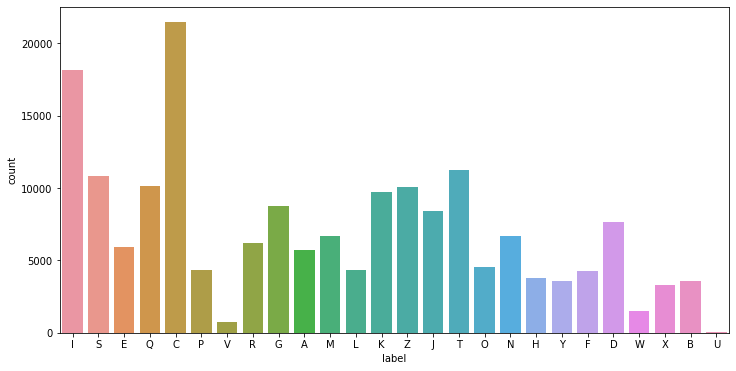

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=train)

**Remarque :** as we can see in the plot above, our dataset isn't balanced: same labels appear much more frequently than others which may lead our predictive model to predict those labels correctly but it won't be good at predicting the rest since they present only a small part from the training dataset, for example : labels U, V, W which seems to be lacking enough training data

### Text augmentation on train set

In [ ]:
#labels to increase
to_aug=["U", "W","V","X","B", "Y", "H", "L","P"]

In [ ]:
my_path = "/drive/My Drive/"
model = gensim.models.KeyedVectors.load_word2vec_format(
     my_path+'BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      # limit=None, # it has 4 billion tokens (4E9)
      limit=int(1E6) # faster load if you limit to most frequent terms
)

In [ ]:
model.save_word2vec_format('model.bin', binary=True)

In [ ]:
aug = naw.WordEmbsAug(model_type='word2vec',model_path='model.bin')

In [ ]:
L=to_aug
te=[]
r=[]
for i in L:
  for t in (train[train['label']==i].index.tolist()):
    text=train[train['label']==i]['cleaned_text'][t]
    aug_text=aug.augment(text, n=10)
    for j in aug_text:
      te.append(j)
      r.append(i)

In [ ]:
aug_data=pd.DataFrame({
    'cleaned_text':te,
    'label':r
})

In [ ]:
aug_data.to_csv('aug_train.csv')

In [ ]:
data1=pd.read_csv('/content/aug_train.csv')

In [ ]:
data1.head()

,Unnamed: 0,cleaned_text,label
0,0,colonization germe métir,U
1,1,coinfected germe métir,U
2,2,viral germe métir,U
3,3,cryptosporidiosis germe métir,U
4,4,reinfected germe métir,U


In [ ]:
data1['label'].unique()

array(['U', 'W', 'V', 'X', 'B', 'Y', 'H', 'L', 'P'], dtype=object)

In [ ]:
data1=data1.drop(columns='Unnamed: 0')

In [ ]:
re_data=data1.copy()

In [ ]:
re_data.head()

,cleaned_text,label
0,colonization germe métir,U
1,coinfected germe métir,U
2,viral germe métir,U
3,cryptosporidiosis germe métir,U
4,reinfected germe métir,U


In [ ]:
data1=re_data.copy()

In [ ]:
data1.reset_index(drop=True, inplace=True)

In [ ]:
data1.head()

,cleaned_text,label
0,colonization germe métir,U
1,coinfected germe métir,U
2,viral germe métir,U
3,cryptosporidiosis germe métir,U
4,reinfected germe métir,U


In [ ]:
train_data=train[['cleaned_text', 'label']]
frames=[data1, train_data]
aug_train=pd.concat(frames)
aug_train=aug_train.dropna()
aug_train.reset_index(drop=True, inplace=True)
aug_train

,cleaned_text,label
0,colonization germe métir,U
1,coinfected germe métir,U
2,viral germe métir,U
3,cryptosporidiosis germe métir,U
4,reinfected germe métir,U
...,...,...
434468,prématurité 32,P
434469,rétinopathie e143 malnutrition e123,H
434470,métastase pariétale,C
434471,lésion cutanée pinta,A


### Predictive Model

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
from sklearn.preprocessing import LabelEncoder

#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(aug_train['label'])

LabelEncoder()

In [ ]:
aug_train.label = label_encoder.transform(aug_train.label)
##repeat same operation for test and val
val.label = label_encoder.transform(val.label)
test.label = label_encoder.transform(test.label)

In [ ]:
import tensorflow as tf
import tensorflow.keras as k
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
text_vec.adapt(aug_train.cleaned_text)

In [ ]:
#construction rapide de graphe de couches (L1, L2, ....) -> sequentiel takes a list of layers
#steps : 1-couche de vectorisation 2-embeddings 3- Layers LSTM 4- Dense Layer with 26 state and activation softmax
model=k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                    text_vec,
                    k.layers.Embedding(input_dim=MAX_VOCAB,
                                       output_dim=HIDDEN_DIM,
                                       mask_zero=True,
                                       ),
                    k.layers.LSTM(units=HIDDEN_DIM,
                                  dropout=.1),
                    #change for part II 26 -> len(label_encoder.classes_)
                    k.layers.Dense(26, activation='softmax')]
                   )
 

In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=aug_train.cleaned_text,
          y=aug_train.label,
          validation_data=(val.cleaned_text, val.label),
          epochs=10)

Epoch 1/10
13578/13578 [==============================] - 114s 8ms/step - loss: 0.8729 - accuracy: 0.7528 - val_loss: 0.9411 - val_accuracy: 0.7313
Epoch 2/10
13578/13578 [==============================] - 100s 7ms/step - loss: 0.5509 - accuracy: 0.8314 - val_loss: 0.8496 - val_accuracy: 0.7471
Epoch 3/10
13578/13578 [==============================] - 101s 7ms/step - loss: 0.4995 - accuracy: 0.8447 - val_loss: 0.8192 - val_accuracy: 0.7558
Epoch 4/10
13578/13578 [==============================] - 100s 7ms/step - loss: 0.4708 - accuracy: 0.8521 - val_loss: 0.8002 - val_accuracy: 0.7617
Epoch 5/10
13578/13578 [==============================] - 100s 7ms/step - loss: 0.4516 - accuracy: 0.8570 - val_loss: 0.7898 - val_accuracy: 0.7655
Epoch 6/10
13578/13578 [==============================] - 100s 7ms/step - loss: 0.4378 - accuracy: 0.8609 - val_loss: 0.7828 - val_accuracy: 0.7669
Epoch 7/10
13578/13578 [==============================] - 99s 7ms/step - loss: 0.4260 - accuracy: 0.8641 - val_l

## Classification du code CIM-10 entier à partir du langage naturel

### Visualisation

our target label ICD10 contains many labels which makes it a bit difficult for us to get clear visualisations. Thus, we've decided to create a new feature which will contain the first letter of each label in ICD10. That way our visualisations will become more clear and easier to be analyzed.

In [ ]:
train.head()

,RawText,ICD10,cleaned_text,label
0,Thrombose veineuse profonde cuisse gauche,I802,thrombose veineuse profonde cuisse gauche,I
1,Hémiplégie post-traumatique,S099,hémiplégie posttraumatique,S
2,Masculinisation avec hyperplasie surrénale,E250,masculinisation hyperplasie surrénale,E
3,Hyperammoniémie cérébrale,E722,hyperammoniémie cérébrale,E
4,Fistule artérioveineuse congénitale périphériq...,Q257,fistule artérioveineuse congénitale périphériq...,Q


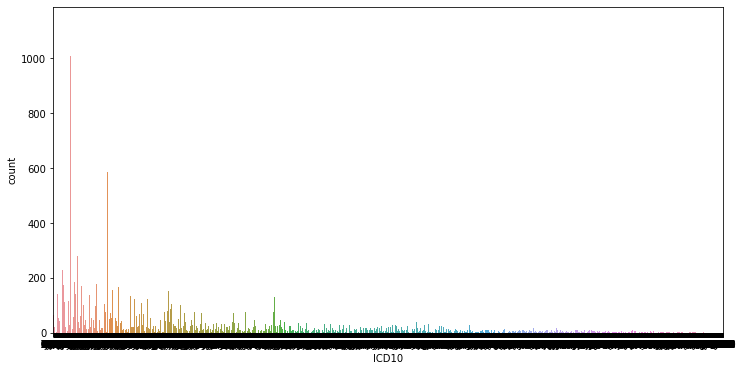

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(x='ICD10',data=train)

In [ ]:
train['ICD10'].value_counts(ascending=True)[:6000]

C503     1
A040     1
T321     1
A218     1
A201     1
        ..
T380    13
T147    13
R680    13
H211    13
M798    13
Name: ICD10, Length: 6000, dtype: int64

**Remarque :** as we can see, almost 6000 of our labels only appear less than 13
which is considered so few comparing it to the size of our data :( .

Solution ? let's apply text augmentation on them so that we generate more rows with those labels without changing the context they belong to :) 

### Text augmentation on train set

In [ ]:
#labels to increase
to_aug=train['ICD10'].value_counts(ascending=True)[:6000].index.tolist()

In [ ]:
L=to_aug
te=[]
r=[]
for i in L:
  for t in (train[train['ICD10']==i].index.tolist()):
    text=train[train['ICD10']==i]['cleaned_text'][t]
    aug_text=aug.augment(text, n=30)
    for j in aug_text:
      te.append(j)
      r.append(i)

In [ ]:
aug_data=pd.DataFrame({
    'cleaned_text':te,
    'label':r
})

In [ ]:
aug_data.to_csv('aug_train.csv')

In [ ]:
data1=pd.read_csv('/content/aug_train.csv')

In [ ]:
data1=data1.drop(columns='Unnamed: 0')

In [ ]:
re_data=data1.copy()

In [ ]:
data1=re_data.copy()

In [ ]:
data1.reset_index(drop=True, inplace=True)

In [ ]:
train_data=train[['cleaned_text', 'label']]
frames=[data1, train_data]
aug_train=pd.concat(frames)
aug_train=aug_train.dropna()
aug_train.reset_index(drop=True, inplace=True)

### Predictive Model

In [ ]:
MAX_VOCAB=10000
HIDDEN_DIM=32

In [ ]:
#label encoder to convert first letters 
label_encoder=LabelEncoder()
#change for all (np.concat(train,test,val))
label_encoder.fit(aug_train['label'])

LabelEncoder()

Test and val contain previously unseen labels

In [ ]:
for i in range(val.shape[0]):
  if val['label'][i] not in labels :
    aug_train = aug_train.append({'cleaned_text': val['cleaned_text'][i], 'label':val['label'][i]}, ignore_index=True)
    val=val.drop(i)
    labels=aug_train['label'].tolist()
for i in range(test.shape[0]):
  if test['label'][i] not in labels :
    aug_train = aug_train.append({'cleaned_text': test['cleaned_text'][i], 'label':test['label'][i]}, ignore_index=True)
    test=test.drop(i)
    labels=aug_train['label'].tolist()
val=val.reset_index()
test=test.reset_index()

In [ ]:
val=val[['cleaned_text','label']]
test=test[['cleaned_text','label']]

In [ ]:
aug_train.label = label_encoder.transform(train.label)
##repeat same operation for test and val
val.label = label_encoder.transform(val.label)
test.label = label_encoder.transform(test.label)

In [ ]:
#first layer for rnn -> couche de vectorisation
text_vec=k.layers.TextVectorization(max_tokens=MAX_VOCAB)

In [ ]:
# adapt the layer to our train data
text_vec.adapt(aug_train.cleaned_text)

In [ ]:
#Here, Conv1D layer is added with 32 filters, kernel_size of 3, padding set to 'same' and activation function set to 'relu'.
#Bidirectional layer is added with LSTM layer as an argument. 
#This will make the LSTM layer bidirectional, processing the input sequence in both forward and backward directions.
model = k.Sequential([k.layers.Input(shape=[], dtype=tf.string),
                      text_vec,
                      k.layers.Embedding(input_dim=MAX_VOCAB,
                                         output_dim=HIDDEN_DIM,
                                         mask_zero=True,
                                         ),
                      k.layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1, return_sequences=True)),
                      k.layers.Bidirectional(k.layers.LSTM(units=HIDDEN_DIM, dropout=0.1)),
                      #k.layers.Flatten(),
                      k.layers.Dense(len(label_encoder.classes_), activation='softmax')]
                     )


In [ ]:
# compile model w adam optimizer and sparse_softmax_crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting the model
model.fit(x=aug_train.RawText,
          y=aug_train.ICD10,
          validation_data=(val.RawText, val.ICD10),
          epochs=50)

❗ Unfortunately, the application of the text augmentation approach on the second part requires much more memory; since we have about 6000 labels to augment and without forgetting the immense size of BioWordVec which alone requires memory to generate the synonyms corresponding to each text. On the other hand, we are sure that it will increase the performance of the model as we noticed in the first part but as we said more memory and computation time are needed :(